In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

# Constants
LOOKUP_MIN = 0.01
FIXED_POINT_SCALE = 1 << 8  # 8-bit fixed-point scaling

# Taylor series-based approximation for log2
def taylor_log2(x, n_terms=3):
    """
    Approximate log2(x) using a Taylor series expansion for log2(1 + x).
    Args:
        x: Input tensor.
        n_terms: Number of terms in the Taylor series expansion.
    Returns:
        Approximated log2 values.
    """
    x_clipped = tf.clip_by_value(x, LOOKUP_MIN, 256.0)  # Clip to avoid invalid values
    exponent = tf.floor(tf.math.log(x_clipped) / tf.math.log(2.0))
    mantissa = x_clipped / tf.pow(2.0, exponent)
    mantissa_shifted = mantissa - 1.0

    log2_mantissa = 0
    for k in range(1, n_terms + 1):
        term = (-1) ** (k + 1) * tf.pow(mantissa_shifted, k) / (k * tf.math.log(2.0))
        log2_mantissa += term

    return exponent + log2_mantissa

# Fixed-point quantization with Taylor series
def log2_quantize(x, method="floor", fractional_bits=3):
    """
    Quantize log2(x) using Taylor series approximation.
    Args:
        x: Input tensor.
        method: Quantization method ('floor' or 'round').
        fractional_bits: Number of fractional bits for quantization.
    Returns:
        Quantized log2 representation.
    """
    log2_x = taylor_log2(x, n_terms=3)
    return tf.floor(log2_x)
    

# Complex CNN with log2 quantization
class LogCNN(tf.keras.Model):
    def __init__(self, input_shape, num_classes):
        super(LogCNN, self).__init__()

        # First Block
        self.conv1 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.pool1 = layers.MaxPooling2D((2, 2))
        self.dropout1 = layers.Dropout(0.25)

        # Second Block
        self.conv3 = layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.bn2 = layers.BatchNormalization()
        self.conv4 = layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.pool2 = layers.MaxPooling2D((2, 2))
        self.dropout2 = layers.Dropout(0.25)

        # Third Block
        self.conv5 = layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.bn3 = layers.BatchNormalization()
        self.conv6 = layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.pool3 = layers.MaxPooling2D((2, 2))
        self.dropout3 = layers.Dropout(0.25)

        # Fully Connected Layers
        self.flatten = layers.Flatten()
        self.fc1 = layers.Dense(512, activation='relu')
        self.bn4 = layers.BatchNormalization()
        self.dropout4 = layers.Dropout(0.5)
        self.fc2 = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        # Logarithmic quantization before each convolutional block
        x = log2_quantize(inputs, method="floor")
        x = self.conv1(x)
        x = self.bn1(x)

        x = log2_quantize(x, method="floor")
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        x = log2_quantize(x, method="floor")
        x = self.conv3(x)
        x = self.bn2(x)

        x = log2_quantize(x, method="floor")
        x = self.conv4(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        x = log2_quantize(x, method="floor")
        x = self.conv5(x)
        x = self.bn3(x)

        x = log2_quantize(x, method="floor")
        x = self.conv6(x)
        x = self.pool3(x)
        x = self.dropout3(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.bn4(x)
        x = self.dropout4(x)
        x = self.fc2(x)

        return x

# Main Training and Evaluation Code
if __name__ == "__main__":
    # Load and preprocess MNIST data
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train = x_train.astype("float32") / 255.0
    x_test = x_test.astype("float32") / 255.0
    x_train = np.expand_dims(x_train, -1)
    x_test = np.expand_dims(x_test, -1)

    # Resize to 32x32 to match larger input shape
    x_train = tf.image.resize(x_train, (32, 32))
    x_test = tf.image.resize(x_test, (32, 32))

    # One-hot encode the labels
    y_train = tf.keras.utils.to_categorical(y_train, 10)
    y_test = tf.keras.utils.to_categorical(y_test, 10)

    # Instantiate and compile the model
    input_shape = (32, 32, 1)
    num_classes = 10
    model = LogCNN(input_shape, num_classes)

    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    # Train the model
    model.fit(x_train, y_train, batch_size=64, epochs=10, validation_split=0.1)

    # Evaluate on test data
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
    print(f"Test Accuracy: {test_acc:.4f}")


Epoch 1/10


C:\Users\prabh\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py:735: UserWarning: Gradients do not exist for variables ['log_cnn/conv2d/kernel', 'log_cnn/conv2d/bias', 'log_cnn/batch_normalization/gamma', 'log_cnn/batch_normalization/beta', 'log_cnn/conv2d_1/kernel', 'log_cnn/conv2d_1/bias', 'log_cnn/conv2d_2/kernel', 'log_cnn/conv2d_2/bias', 'log_cnn/batch_normalization_1/gamma', 'log_cnn/batch_normalization_1/beta', 'log_cnn/conv2d_3/kernel', 'log_cnn/conv2d_3/bias', 'log_cnn/conv2d_4/kernel', 'log_cnn/conv2d_4/bias', 'log_cnn/batch_normalization_2/gamma', 'log_cnn/batch_normalization_2/beta'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


844/844 ━━━━━━━━━━━━━━━━━━━━ 113s 131ms/step - accuracy: 0.6951 - loss: 3.0181 - val_accuracy: 0.8980 - val_loss: 0.3214
Epoch 2/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 119s 141ms/step - accuracy: 0.9145 - loss: 0.2656 - val_accuracy: 0.9225 - val_loss: 0.2467
Epoch 3/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 116s 137ms/step - accuracy: 0.9268 - loss: 0.2218 - val_accuracy: 0.9422 - val_loss: 0.1799
Epoch 4/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 118s 140ms/step - accuracy: 0.9367 - loss: 0.1868 - val_accuracy: 0.9423 - val_loss: 0.1790
Epoch 5/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 117s 139ms/step - accuracy: 0.9410 - loss: 0.1798 - val_accuracy: 0.9330 - val_loss: 0.1989
Epoch 6/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 129s 123ms/step - accuracy: 0.9460 - loss: 0.1641 - val_accuracy: 0.9413 - val_loss: 0.1903
Epoch 7/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 116s 137ms/step - accuracy: 0.9472 - loss: 0.1582 - val_accuracy: 0.9448 - val_loss: 0.1719
Epoch 8/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 117s 138ms/step - accuracy: 0.9485 - loss: 0.15

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

lookup_min = 0.01
fixed_point_scale = 1 << 8

def taylor_approx(x, n_terms=3):
    x_clipped = tf.clip_by_value(x, lookup_min, 256.0)
    exponent = tf.floor(tf.math.log(x_clipped) / tf.math.log(2.0))
    mantissa = x_clipped / tf.pow(2.0, exponent)
    mantissa_shifted = mantissa - 1.0

    log2_mantissa = 0
    for k in range(1, n_terms + 1):
        term = (-1) ** (k + 1) * tf.pow(mantissa_shifted, k) / (k * tf.math.log(2.0))
        log2_mantissa += term

    return exponent + log2_mantissa

def log_quantize(x):
    log2_x = taylor_log2(x, n_terms=3)
    return tf.floor(log2_x)

class LogCNN(tf.keras.Model):
    def __init__(self, input_shape, num_classes):
        super(LogCNN, self).__init__()
        self.conv1 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.pool1 = layers.MaxPooling2D((2, 2))
        self.dropout1 = layers.Dropout(0.25)
        self.conv3 = layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.bn2 = layers.BatchNormalization()
        self.conv4 = layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.pool2 = layers.MaxPooling2D((2, 2))
        self.dropout2 = layers.Dropout(0.25)
        self.conv5 = layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.bn3 = layers.BatchNormalization()
        self.conv6 = layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.pool3 = layers.MaxPooling2D((2, 2))
        self.dropout3 = layers.Dropout(0.25)
        self.flatten = layers.Flatten()
        self.fc1 = layers.Dense(512, activation='relu')
        self.bn4 = layers.BatchNormalization()
        self.dropout4 = layers.Dropout(0.5)
        self.fc2 = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = log2_quantize(inputs)
        x = self.conv1(x)
        x = self.bn1(x)
        x = log2_quantize(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        x = log2_quantize(x)
        x = self.conv3(x)
        x = self.bn2(x)
        x = log2_quantize(x)
        x = self.conv4(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        x = log2_quantize(x)
        x = self.conv5(x)
        x = self.bn3(x)
        x = log2_quantize(x)
        x = self.conv6(x)
        x = self.pool3(x)
        x = self.dropout3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.bn4(x)
        x = self.dropout4(x)
        x = self.fc2(x)
        return x

if __name__ == "__main__":
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train = x_train.astype("float32") / 255.0
    x_test = x_test.astype("float32") / 255.0
    x_train = np.expand_dims(x_train, -1)
    x_test = np.expand_dims(x_test, -1)
    x_train = tf.image.resize(x_train, (32, 32))
    x_test = tf.image.resize(x_test, (32, 32))
    y_train = tf.keras.utils.to_categorical(y_train, 10)
    y_test = tf.keras.utils.to_categorical(y_test, 10)
    input_shape = (32, 32, 1)
    num_classes = 10
    model = LogCNN(input_shape, num_classes)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(x_train, y_train, batch_size=64, epochs=10, validation_split=0.1)
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
    print(f"Test Accuracy: {test_acc:.4f}")


Epoch 1/10


C:\Users\prabh\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py:735: UserWarning: Gradients do not exist for variables ['log_cnn_1/conv2d_6/kernel', 'log_cnn_1/conv2d_6/bias', 'log_cnn_1/batch_normalization_4/gamma', 'log_cnn_1/batch_normalization_4/beta', 'log_cnn_1/conv2d_7/kernel', 'log_cnn_1/conv2d_7/bias', 'log_cnn_1/conv2d_8/kernel', 'log_cnn_1/conv2d_8/bias', 'log_cnn_1/batch_normalization_5/gamma', 'log_cnn_1/batch_normalization_5/beta', 'log_cnn_1/conv2d_9/kernel', 'log_cnn_1/conv2d_9/bias', 'log_cnn_1/conv2d_10/kernel', 'log_cnn_1/conv2d_10/bias', 'log_cnn_1/batch_normalization_6/gamma', 'log_cnn_1/batch_normalization_6/beta'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


844/844 ━━━━━━━━━━━━━━━━━━━━ 103s 117ms/step - accuracy: 0.6987 - loss: 2.3192 - val_accuracy: 0.9327 - val_loss: 0.2100
Epoch 2/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 111s 132ms/step - accuracy: 0.9324 - loss: 0.2047 - val_accuracy: 0.9568 - val_loss: 0.1383
Epoch 3/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 115s 136ms/step - accuracy: 0.9504 - loss: 0.1533 - val_accuracy: 0.9537 - val_loss: 0.1453
Epoch 4/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 117s 139ms/step - accuracy: 0.9539 - loss: 0.1387 - val_accuracy: 0.9540 - val_loss: 0.1551
Epoch 5/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 111s 131ms/step - accuracy: 0.9612 - loss: 0.1157 - val_accuracy: 0.9557 - val_loss: 0.1417
Epoch 6/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 114s 135ms/step - accuracy: 0.9644 - loss: 0.1085 - val_accuracy: 0.9617 - val_loss: 0.1293
Epoch 7/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 113s 134ms/step - accuracy: 0.9653 - loss: 0.1075 - val_accuracy: 0.9585 - val_loss: 0.1490
Epoch 8/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 114s 135ms/step - accuracy: 0.9692 - loss: 0.09

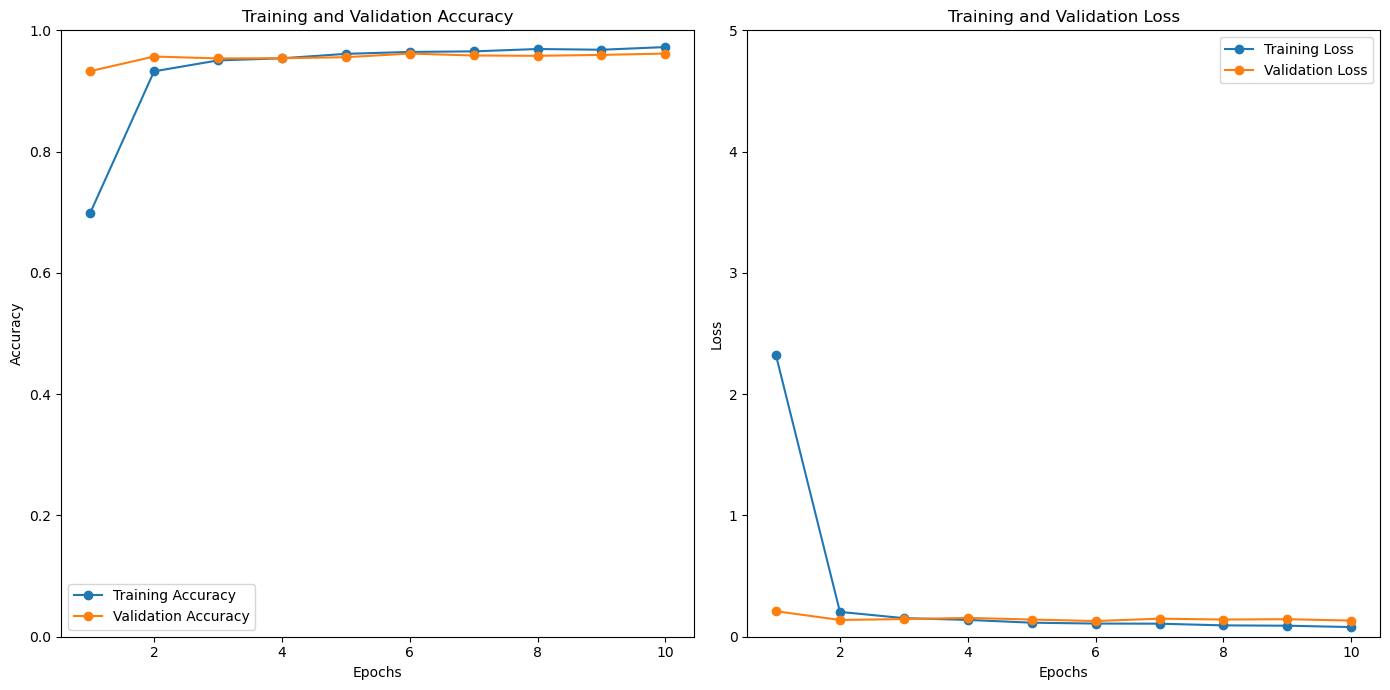

In [1]:
import matplotlib.pyplot as plt

# Training and validation metrics
accuracy = [0.6987, 0.9324, 0.9504, 0.9539, 0.9612, 0.9644, 0.9653, 0.9692, 0.9680, 0.9724]
val_accuracy = [0.9327, 0.9568, 0.9537, 0.9540, 0.9557, 0.9617, 0.9585, 0.9580, 0.9595, 0.9617]
loss = [2.3192, 0.2047, 0.1533, 0.1387, 0.1157, 0.1085, 0.1075, 0.0935, 0.0908, 0.0796]
val_loss = [0.2100, 0.1383, 0.1453, 0.1551, 0.1417, 0.1293, 0.1490, 0.1416, 0.1445, 0.1331]

# Number of epochs
epochs = range(1, 11)

# Plotting accuracy
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.0, 1.0)  # Scale for accuracy
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0.0, 5.0)  # Scale for loss
plt.legend()

plt.tight_layout()
plt.show()


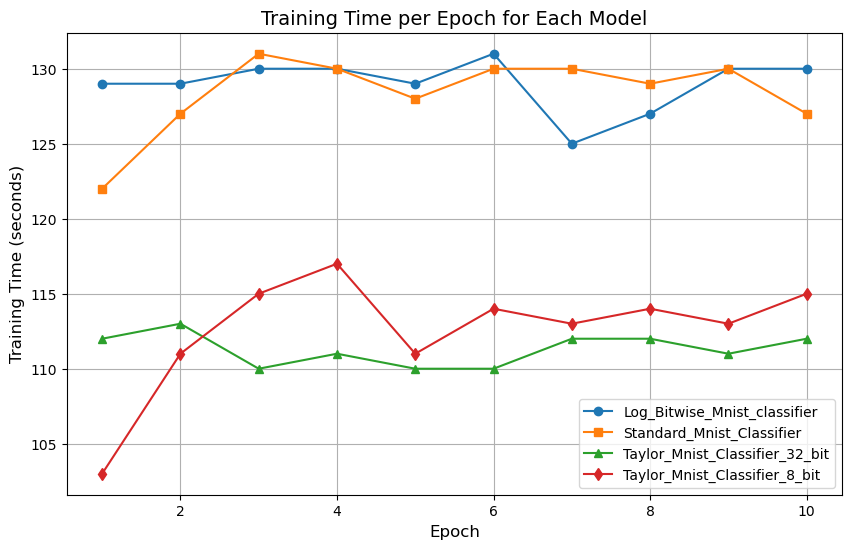

In [5]:
import matplotlib.pyplot as plt

# Data for training times (in seconds) per epoch for each model
model_1_times = [129, 129, 130, 130, 129, 131, 125, 127, 130, 130]  # First CNN
model_2_times = [122, 127, 131, 130, 128, 130, 130, 129, 130, 127]  # Second CNN
model_3_times = [112, 113, 110, 111, 110, 110, 112, 112, 111, 112]  # Third CNN
model_4_times = [103, 111, 115, 117, 111, 114, 113, 114, 113, 115]  # Fourth CNN

# Names of the models
model_1_name = "Log_Bitwise_Mnist_classifier"
model_2_name = "Standard_Mnist_Classifier"
model_3_name = "Taylor_Mnist_Classifier_32_bit"
model_4_name = "Taylor_Mnist_Classifier_8_bit"

epochs = range(1, 11)

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(epochs, model_1_times, marker='o', label=model_1_name)
plt.plot(epochs, model_2_times, marker='s', label=model_2_name)
plt.plot(epochs, model_3_times, marker='^', label=model_3_name)
plt.plot(epochs, model_4_times, marker='d', label=model_4_name)

# Customizing the plot
plt.title("Training Time per Epoch for Each Model", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Training Time (seconds)", fontsize=12)
plt.legend()
plt.grid(True)

# Displaying the plot
plt.show()


In [11]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

lookup_min = 0.01  # Minimum value to clip inputs
fixed_point_scale = 1 << 8  # Fixed-point scaling for hardware compatibility

# Precompute a lookup table for the integer part of log2(x) for x in [1, 256]
log2_lookup_np = np.log2(np.arange(1, 257))  # NumPy array for log2 of 1 to 256
log2_lookup = tf.constant(log2_lookup_np, dtype=tf.float32)  # Convert to TensorFlow constant

def compute_exponent_and_fraction(x):
    # Clip values to ensure no invalid input
    x_clipped = tf.clip_by_value(x, lookup_min, 256.0)

    # Extract integer part using truncation and cast to int
    integer_part = tf.cast(tf.math.floor(x_clipped), tf.int32)

    # Compute fractional part
    fractional_part = x_clipped - tf.cast(integer_part, tf.float32)

    return integer_part, fractional_part

def taylor_approx_with_lookup(x, n_terms=2):
    # Reduce Taylor terms for hardware efficiency
    x_clipped = tf.clip_by_value(x, lookup_min, 256.0)

    # Compute integer and fractional parts
    exponent, fractional_part = compute_exponent_and_fraction(x_clipped)

    # Compute mantissa (shift fractional part to [1, 2))
    mantissa = 1.0 + fractional_part
    mantissa_shifted = mantissa - 1.0

    # Lookup integer part
    log2_integer_part = tf.gather(log2_lookup, tf.clip_by_value(exponent, 0, 255))

    # Approximate fractional part using fewer Taylor terms
    log2_fractional_part = mantissa_shifted / tf.math.log(2.0)

    return log2_integer_part + log2_fractional_part

def log_quantize(x):
    log2_x = taylor_approx_with_lookup(x, n_terms=2)  # Use fewer terms for efficiency
    return tf.floor(log2_x)

# Define the CNN model with reduced filter sizes for hardware efficiency
class LogCNN(tf.keras.Model):
    def __init__(self, input_shape, num_classes):
        super(LogCNN, self).__init__()
        self.conv1 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')
        self.pool1 = layers.MaxPooling2D((2, 2))
        self.conv3 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.bn2 = layers.BatchNormalization()
        self.pool2 = layers.MaxPooling2D((2, 2))
        self.conv4 = layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.bn3 = layers.BatchNormalization()
        self.pool3 = layers.MaxPooling2D((2, 2))
        self.flatten = layers.Flatten()
        self.fc1 = layers.Dense(256, activation='relu')  # Reduced size for hardware
        self.bn4 = layers.BatchNormalization()
        self.fc2 = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.conv1(inputs)  # Avoid quantization at input for better precision
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = self.bn2(x)
        x = self.pool2(x)
        x = self.conv4(x)
        x = self.bn3(x)
        x = self.pool3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.bn4(x)
        x = self.fc2(x)
        return x

if __name__ == "__main__":
    # Load MNIST dataset
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train = x_train.astype("float32") / 255.0
    x_test = x_test.astype("float32") / 255.0
    x_train = np.expand_dims(x_train, -1)
    x_test = np.expand_dims(x_test, -1)

    # Resize to 32x32 for compatibility with the model
    x_train = tf.image.resize(x_train, (32, 32))
    x_test = tf.image.resize(x_test, (32, 32))

    # One-hot encode the labels
    y_train = tf.keras.utils.to_categorical(y_train, 10)
    y_test = tf.keras.utils.to_categorical(y_test, 10)

    # Define model input shape and number of classes
    input_shape = (32, 32, 1)
    num_classes = 10

    # Initialize and compile the model
    model = LogCNN(input_shape, num_classes)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                  loss="categorical_crossentropy", metrics=["accuracy"])

    # Train the model
    model.fit(x_train, y_train, batch_size=64, epochs=10, validation_split=0.1)  # Larger batch size

    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
    print(f"Test Accuracy: {test_acc:.4f}")


Epoch 1/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 34s 38ms/step - accuracy: 0.8959 - loss: 0.3181 - val_accuracy: 0.9852 - val_loss: 0.0462
Epoch 2/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 32s 38ms/step - accuracy: 0.9878 - loss: 0.0395 - val_accuracy: 0.9918 - val_loss: 0.0279
Epoch 3/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 33s 39ms/step - accuracy: 0.9919 - loss: 0.0248 - val_accuracy: 0.9910 - val_loss: 0.0370
Epoch 4/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 40s 47ms/step - accuracy: 0.9937 - loss: 0.0187 - val_accuracy: 0.9912 - val_loss: 0.0302
Epoch 5/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 36s 42ms/step - accuracy: 0.9939 - loss: 0.0167 - val_accuracy: 0.9917 - val_loss: 0.0313
Epoch 6/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 35s 41ms/step - accuracy: 0.9962 - loss: 0.0118 - val_accuracy: 0.9923 - val_loss: 0.0364
Epoch 7/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 37s 43ms/step - accuracy: 0.9955 - loss: 0.0137 - val_accuracy: 0.9902 - val_loss: 0.0419
Epoch 8/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 33s 39ms/step - accuracy: 0.9969 - loss: 0.0084 - 

In [13]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

lookup_min = 0.01

log2_lookup_np = np.log2(np.arange(1, 257))
log2_lookup = tf.constant(log2_lookup_np, dtype=tf.float32)

def int_frac(x):
    x_clipped = tf.clip_by_value(x, lookup_min, 256.0)
    integer_part = tf.cast(tf.math.floor(x_clipped), tf.int32)
    fractional_part = x_clipped - tf.cast(integer_part, tf.float32)
    return integer_part, fractional_part

def taylor_approx(x, n_terms=2):
    x_clipped = tf.clip_by_value(x, lookup_min, 256.0)
    exponent, fractional_part = int_frac(x_clipped)
    mantissa = 1.0 + fractional_part
    mantissa_shifted = mantissa - 1.0
    log2_integer_part = tf.gather(log2_lookup, tf.clip_by_value(exponent, 0, 255))
    log2_fractional_part = mantissa_shifted / tf.math.log(2.0)
    return log2_integer_part + log2_fractional_part

def log_quantize(x):
    log2_x = taylor_approx(x, n_terms=2)
    return tf.floor(log2_x)

class LogCNN(tf.keras.Model):
    def __init__(self, input_shape, num_classes):
        super(LogCNN, self).__init__()
        self.conv1 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')
        self.pool1 = layers.MaxPooling2D((2, 2))
        self.conv3 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.bn2 = layers.BatchNormalization()
        self.pool2 = layers.MaxPooling2D((2, 2))
        self.conv4 = layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.bn3 = layers.BatchNormalization()
        self.pool3 = layers.MaxPooling2D((2, 2))
        self.flatten = layers.Flatten()
        self.fc1 = layers.Dense(256, activation='relu')
        self.bn4 = layers.BatchNormalization()
        self.fc2 = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = self.bn2(x)
        x = self.pool2(x)
        x = self.conv4(x)
        x = self.bn3(x)
        x = self.pool3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.bn4(x)
        x = self.fc2(x)
        return x

if __name__ == "__main__":
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train = x_train.astype("float32") / 255.0
    x_test = x_test.astype("float32") / 255.0
    x_train = np.expand_dims(x_train, -1)
    x_test = np.expand_dims(x_test, -1)
    x_train = tf.image.resize(x_train, (32, 32))
    x_test = tf.image.resize(x_test, (32, 32))
    y_train = tf.keras.utils.to_categorical(y_train, 10)
    y_test = tf.keras.utils.to_categorical(y_test, 10)
    input_shape = (32, 32, 1)
    num_classes = 10
    model = LogCNN(input_shape, num_classes)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                  loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(x_train, y_train, batch_size=64, epochs=10, validation_split=0.1)
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
    print(f"Test Accuracy: {test_acc:.4f}")


Epoch 1/10
191/844 ━━━━━━━━━━━━━━━━━━━━ 22s 34ms/step - accuracy: 0.7240 - loss: 0.7985

KeyboardInterrupt: 